## Data Preparation
### 1. Wrangling

Time to get data prepared for further analysis

In [1]:
import pandas as pd

import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt

In [72]:
df = pd.read_csv('RawData.csv', names=['company', 'review', 'rating', 'date', 'date_collected'])

In [73]:
df.head()

,company,review,rating,date,date_collected
0,Woolworths,-Great working environment with very good supp...,5.0,2 years ago,"2020, January"
1,Woolworths,"I enjoyed what I am doing, it's a tough job, b...",3.0,4 years ago,"2020, January"
2,Woolworths,Working with staff everyday. The ability to wo...,4.0,4 years ago,"2020, January"
3,Woolworths,Great opportunities for career advancement for...,4.0,4 years ago,"2020, January"
4,Woolworths,During peek sales periods; casuals get great h...,3.0,4 years ago,"2020, January"


Having a look at number of reviews collected for each rating, it seems categories are fairly balanced apart from rare `zero ratings`. I will drop `zero ratings` as they can hardly be of value for this dataset and analytics.

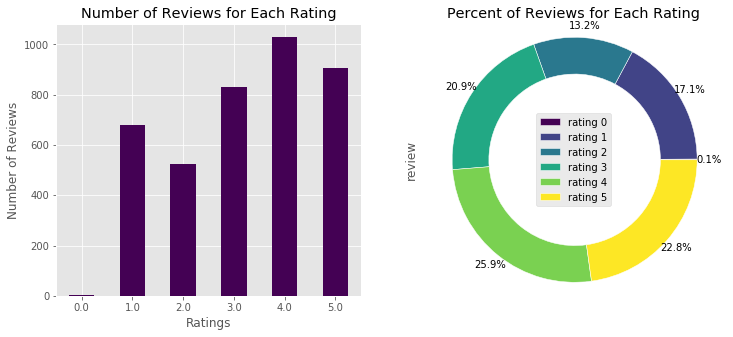

In [4]:
with plt.style.context('ggplot'):
    fig, axs = plt.subplots(1, 2, figsize=(12,5))
    

    bar_chart = df[['review', 'rating']].groupby(by=['rating']).count()['review'].plot(
        kind='bar', 
        ax=axs[0], 
        title='Number of Reviews for Each Rating', 
        rot=0, 
        colormap='viridis')
    axs[0].set_xlabel('Ratings')
    axs[0].set_ylabel('Number of Reviews')
    
    pie_chart = df[['review', 'rating']].groupby(by=['rating']).count()['review'].plot(
        kind='pie', 
        ax=axs[1], 
        title='Percent of Reviews for Each Rating', 
        colormap='viridis', 
        autopct='%1.1f%%', 
        pctdistance=1.1, 
        wedgeprops=dict(width=0.3, edgecolor='w'), 
        labels=None)
    axs[1].axis('equal')
    axs[1].legend(['rating 0', 'rating 1', 'rating 2', 'rating 3', 'rating 4', 'rating 5'] ,loc='center')

    plt.show()
    plt.close()

In [74]:
df = df[df.rating != 0]
df.reset_index()

,index,company,review,rating,date,date_collected
0,0,Woolworths,-Great working environment with very good supp...,5.0,2 years ago,"2020, January"
1,1,Woolworths,"I enjoyed what I am doing, it's a tough job, b...",3.0,4 years ago,"2020, January"
2,2,Woolworths,Working with staff everyday. The ability to wo...,4.0,4 years ago,"2020, January"
3,3,Woolworths,Great opportunities for career advancement for...,4.0,4 years ago,"2020, January"
4,4,Woolworths,During peek sales periods; casuals get great h...,3.0,4 years ago,"2020, January"
...,...,...,...,...,...,...
3965,3969,Coles,The people I work with are great and I like wh...,3.0,3 months ago,"2020, January"
3966,3970,Coles,Teamwork Hour cuts,4.0,4 years ago,"2020, January"
3967,3971,Coles,Some select colleges Management customers sup...,1.0,2 months ago,"2020, January"
3968,3972,Coles,Hometime ... is the only good thing Terrible ...,1.0,2 years ago,"2020, January"


It might be a bit of insightful understanding to have a quick look at collected review_texts. Unprocessed text length distribution shows that most of the reviews are about 150 long, though there are cases as long as 2000 characters.

In [75]:
df['review_length'] = df['review'].str.len()
df.head()

,company,review,rating,date,date_collected,review_length
0,Woolworths,-Great working environment with very good supp...,5.0,2 years ago,"2020, January",578
1,Woolworths,"I enjoyed what I am doing, it's a tough job, b...",3.0,4 years ago,"2020, January",343
2,Woolworths,Working with staff everyday. The ability to wo...,4.0,4 years ago,"2020, January",320
3,Woolworths,Great opportunities for career advancement for...,4.0,4 years ago,"2020, January",446
4,Woolworths,During peek sales periods; casuals get great h...,3.0,4 years ago,"2020, January",454


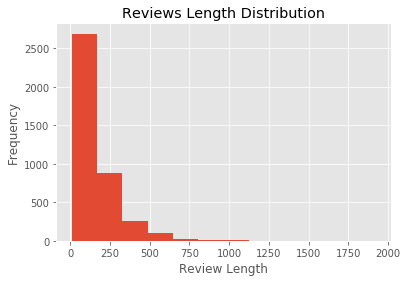

In [7]:
with plt.style.context('ggplot'):
    hist_chart = df['review_length'].plot(
        kind='hist', 
        bins=12, 
        title='Reviews Length Distribution')
    hist_chart.set_xlabel('Review Length')

In [8]:
df['review_length'].describe()

count    3970.000000
mean      162.735768
std       139.179513
min         8.000000
25%        76.000000
50%       118.000000
75%       200.000000
max      1925.000000
Name: review_length, dtype: float64

### 2. Text Cleaning
----------------------
The reviews’ content need to be cleaned for __`feature engineering`__. In that regard, special characters, punctuation, and stop words should be removed. And text should undergo `stemming` or `lemmatization` process before creating data features.


I will save cleaned text in a new column `review_cleaned`

In [9]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords #(may require to nltk.download('stopwords') before using)
from nltk.stem import WordNetLemmatizer #(may require to nltk.download('wordnet') before using)
from nltk.stem import PorterStemmer

First thing I remove `possessive pronouns`:

In [76]:
df['review_cleaned'] = df['review'].str.replace("'s", "")

Then let's remove punctuation and special characters .And turn every word into lowercase.

In [77]:
tokenizer = RegexpTokenizer(r'\w+')

In [78]:
df['review_cleaned'] = df['review_cleaned'].apply(lambda x: tokenizer.tokenize(x.lower()))

Now let's remove `stop words`

Considering the fact that this is a __`sentiment`__ classification after all, I decided not to remove words __`not`__ & __`but`__.

In [79]:
stop_words = stopwords.words('english')
stop_words.remove('not')
stop_words.remove('but')

In [80]:
# function used to remove stop words from ant text
def remove_stop_words(text):
    review = [word for word in text if word not in stop_words]
    return review

In [81]:
df['review_cleaned'] = df['review_cleaned'].apply(lambda x: remove_stop_words(x))

Probably as final step, let's lemmatize words and join them together again:

In [82]:
lemmatizer = WordNetLemmatizer()

# used to lemmatize any text
def word_lemmatizer(text):
    review = " ".join([lemmatizer.lemmatize(x) for x in text])
    return review

df['review_cleaned'] = df['review_cleaned'].apply(lambda x: word_lemmatizer(x))

In [51]:
# Option for stemming

"""

stemmer = PorterStemmer()

# used to stemming any text
def word_stemmer(text):
    review = " ".join([stemmer.stem(x) for x in text])
    return review

df['review_cleaned'] = df['review_cleaned'].apply(lambda x: word_stemmer(x))

"""

'\n\nstemmer = PorterStemmer()\n\n# used to stemming any text\ndef word_stemmer(text):\n    review = " ".join([stemmer.stem(x) for x in text])\n    return review\n\ndf[\'review_cleaned\'] = df[\'review_cleaned\'].apply(lambda x: word_stemmer(x))\n\n'

In [83]:
df.head()

,company,review,rating,date,date_collected,review_length,review_cleaned
0,Woolworths,-Great working environment with very good supp...,5.0,2 years ago,"2020, January",578,great working environment good support co work...
1,Woolworths,"I enjoyed what I am doing, it's a tough job, b...",3.0,4 years ago,"2020, January",343,enjoyed tough job but loved camaraderie within...
2,Woolworths,Working with staff everyday. The ability to wo...,4.0,4 years ago,"2020, January",320,working staff everyday ability work different ...
3,Woolworths,Great opportunities for career advancement for...,4.0,4 years ago,"2020, January",446,great opportunity career advancement right peo...
4,Woolworths,During peek sales periods; casuals get great h...,3.0,4 years ago,"2020, January",454,peek sale period casuals get great hour manage...


Considering the fact that this is a sentiment classification, I will reduce labels categorries as follows:
* Ratings 1 & 2 → sentiment_category 0 → meaning **_UNENGAGED_**
* Rating 3 → sentiment_category 1 → meaning **_MEDIOCRE
_**
* Rattings 4 & 5 → sentiment_category 2 → meaning **_STOKED_**


In [84]:
# function to return sentiment_category based on reviews' rating
def sentiment(rating):
    if rating == 1 or rating == 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

In [85]:
df['sentiment_category'] = df['rating'].apply(lambda x: sentiment(x))

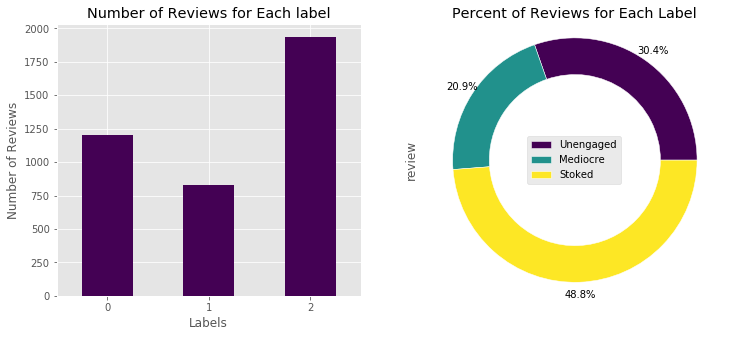

In [21]:
with plt.style.context('ggplot'):
    fig, axs = plt.subplots(1, 2, figsize=(12,5))
    

    bar_chart = df[['review', 'sentiment_category']].groupby(by=['sentiment_category']).count()['review'].plot(
        kind='bar', 
        ax=axs[0], 
        title='Number of Reviews for Each label', 
        rot=0, 
        colormap='viridis')
    axs[0].set_xlabel('Labels')
    axs[0].set_ylabel('Number of Reviews')
    
    pie_chart = df[['review', 'sentiment_category']].groupby(by=['sentiment_category']).count()['review'].plot(
        kind='pie', 
        ax=axs[1], 
        title='Percent of Reviews for Each Label', 
        colormap='viridis', 
        autopct='%1.1f%%', 
        pctdistance=1.1, 
        wedgeprops=dict(width=0.3, edgecolor='w'), 
        labels=None)
    axs[1].axis('equal')
    axs[1].legend(['Unengaged', 'Mediocre', 'Stoked'] ,loc='center')

    plt.show()
    plt.close()

Let's save part of the data frame to be used for model development

In [70]:
import pickle

In [86]:
with open ('pickle_cleaned_data', 'wb') as output:
    pickle.dump(df[['review_cleaned', 'sentiment_category']], output)